### Questions
- Is entropy exclusive to decision trees? No

### Objectives
* Build a decision tree classifier using sklearn
* Analyze and improve decision tree classifier iteratively
* Apply best practices to decision trees

### What are the parts of a decision tree?
- Root Node, what is this? 
    - whatever we want to start with? features, data, etc
    - data goes here
- Branches
    - node with leaves
    - conditional statement
    - splits the data into subsets
- Interior (Decision) Nodes
    - contains data 
- Leaf Node
    - Node w/o children
    - Where a decision is made
    - In the case of classification, a data point gets assigned a label
    - In the case of regression, a data gets assigned a target value
    
![](decision-tree.jpeg)

### What is a Gini Index and What is Entropy?

![](weather.jpeg)

In [6]:
# Calcualte the gini index for humidity (high normal)
# gini index -> purity of a split (are we dividing play_yes and play_no well?)
# 0 = normal, 1 = high
# humidity_play_no = ['high', 'high', 'normal', 'high', 'high']
humidity_play_no = [1, 1, 0, 1, 1]
humidity_play_yes = [1, 1, 0, 0, 0, 0, 0, 1, 0]


# P(normal humidity|no play)
no_normal = 0.20 # 1 out 5 -> 0.20^2 = 0.04
# P(high humidity | no play) 
no_high = 0.80 # 4 out of 5 -> 0.80^2 = 0.64

# P(normal humidity|yes play)
yes_normal = 6/9 

# P(high humidity|yes play)
yes_high = 3/9

# Weights the larger probabilities
# if g << 1 both numbers must be small (close)
# if g ~ 1 one condition has really high probability
# if our gini index is really close to 1, what does that mean?
# this means that one of our feature values is dominating our array

# if humidity_play_0 = [1, 1, 1, 1, 1] 
# P(n|no) = 0.0
# P(h|no) = 1.0
gini_play_no = no_normal**2 + no_high**2  # 0.68
gini_play_no = 1 - gini_play_no


# g ~ 1 both numbers must be small (close)
# g ~ 0 one condition has really high probability

gini_play_yes = yes_normal**2 + yes_high**2 # 0.5555....
gini_play_yes = 1 - gini_play_yes


# gini ~ 1 this means really really impure split
# gini ~ 0 this means really really pure split
# weighted average

gini = gini_play_no * (2/14) + gini_play_yes*(12/14)
print("g_humid = {}".format(gini))

g_humid = 0.42666666666666664


### Outline
* Discuss Gini Index/Entropy
* Build a Decision Tree
* Visualize It

In [7]:
import pandas as pd
import numpy as np

import scipy

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest


import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def create_df_load_set(load_set):
    dataset = load_set()
    data = dataset.data
    columns = dataset.feature_names
    target = dataset.target
    df = pd.DataFrame(data, columns=columns)
    df['target'] = target
    return df

In [9]:
df = create_df_load_set(load_iris)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [10]:
df.target.unique()

array([0, 1, 2])

### Let's discuss multicollinearity of decision trees

In [12]:
df.corr().abs()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,0.117570,0.871754,0.817941,0.782561
sepal width (cm),0.117570,1.000000,0.428440,0.366126,0.426658
petal length (cm),0.871754,0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,0.366126,0.962865,1.000000,0.956547
target,0.782561,0.426658,0.949035,0.956547,1.000000


### What do we notice about the correlation matrix?
- petalwidth has highest correlation with target
- we have multicollinearity with petal length and petal width
- sepal length and petal length and petal width


### Is that a problem?
- In Linear Regression this is a problem
- In Logistic Regression this is also a problem

- Mathematically, multicollinearity isn't an issue for non parametric methods. 
- Determine that your data is conditioned

In [83]:
x, y = df.drop(['target','petal width (cm)'], axis=1), df.target

In [84]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.50)

### Let's build a decision tree

In [85]:
clf = DecisionTreeClassifier()
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [86]:
clf.score(xtrain, ytrain)

1.0

In [87]:
clf.score(xtest, ytest) 

0.96

### Why do we get overfitting? 
- Decision Tree Classifier is 'going too far'
- They're inherently greedy

### Let's visualize our tree
[Source is Medium Article](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)

In [88]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import pydotplus

petal length (cm)


(array([37., 13.,  0.,  3.,  8., 26., 29., 18., 11.,  5.]),
 array([1.  , 1.59, 2.18, 2.77, 3.36, 3.95, 4.54, 5.13, 5.72, 6.31, 6.9 ]),
 <a list of 10 Patch objects>)

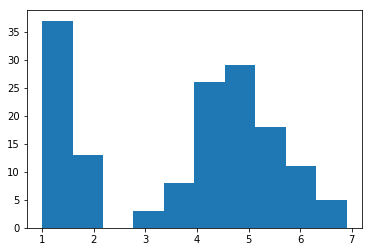

In [89]:
print(df.columns[2])
plt.hist(df[df.columns[2]])

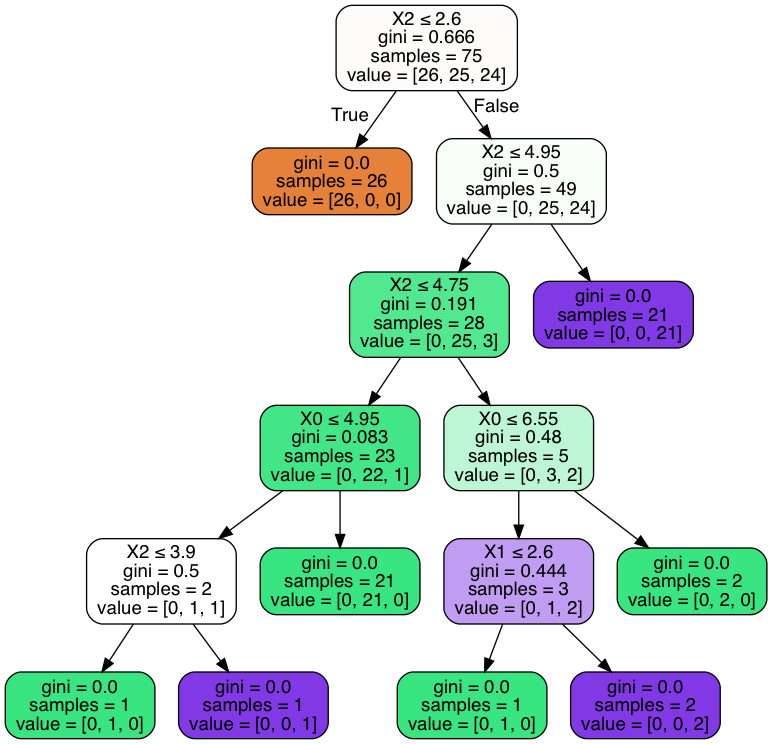

In [90]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### the depth of the search is leading overfitting
### the multicollinearity could lead to overfitting...lead bias

### If you're increasing robustness but test score stays stagnant, what does this indicate?

### Let's tune some hyperparameters

In [36]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [37]:
clf.score(xtrain, ytrain)

0.96

In [38]:
clf.score(xtest, ytest) 

0.96

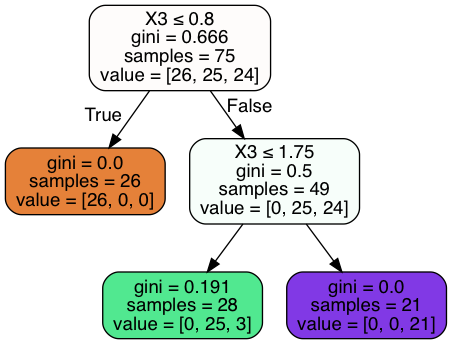

In [39]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [40]:
clf = DecisionTreeClassifier(min_samples_leaf=10)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [41]:
clf.score(xtrain, ytrain), clf.score(xtest, ytest)

(0.96, 0.96)

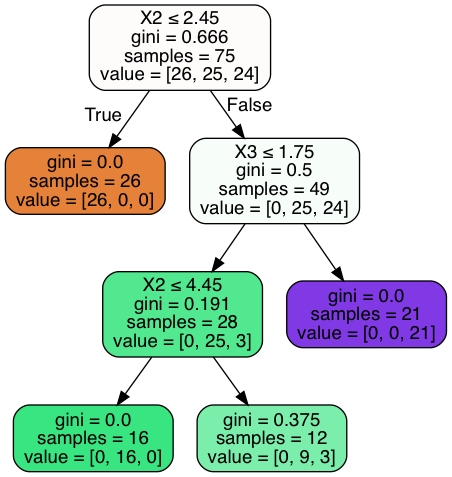

In [42]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Still have splits that are overfitting 'chasing' points.

In [63]:
clf = DecisionTreeClassifier(criterion='entropy', splitter='random', min_samples_leaf=10, max_depth=3)
clf.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='random')

In [64]:
clf.score(xtrain, ytrain)

0.84

In [65]:
clf.score(xtest, ytest) 

0.7733333333333333

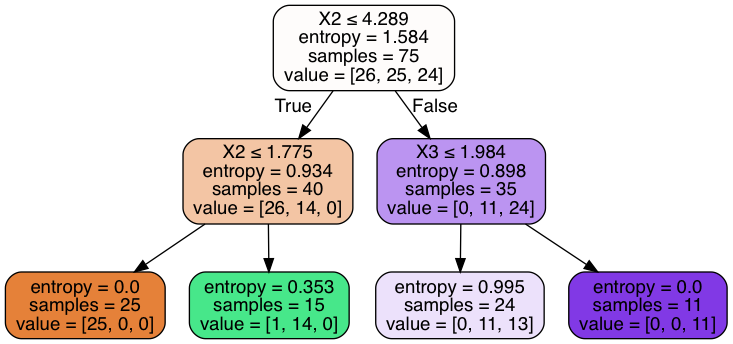

In [66]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### We tuned some hyperparameters, now let's look at attributes

In [56]:
feature_importance_vals = clf.feature_importances_
features = x.columns
feature_importance_vals, features

(array([0.        , 0.        , 0.54409135, 0.45590865]),
 Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
        'petal width (cm)'],
       dtype='object'))

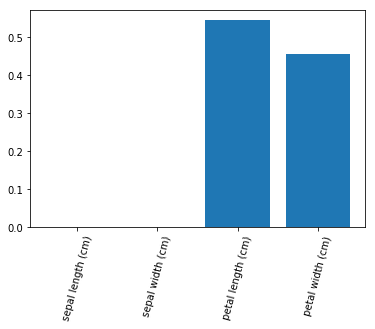

In [57]:
plt.bar(features, feature_importance_vals)
plt.xticks(features, features, rotation=75)
plt.show()

### Multicollinearity makes feature importances impossible to interpret

In [58]:
scipy.sparse.csr_matrix.todense(clf.decision_path(xtest)) # SHOWS THE NODES THAT INTERACT WITH EACH X VALUE AS 1

matrix([[1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [1, 0, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 0, 1, 0],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],


In [16]:
xtest.shape

(30, 4)

In [17]:
xtest.iloc[0]

sepal length (cm)    6.0
sepal width (cm)     2.2
petal length (cm)    5.0
petal width (cm)     1.5
Name: 119, dtype: float64

In [18]:
clf.predict(xtest.iloc[0].values.reshape(1, -1))

array([1])

### Assessment
* Learned about overfitting decision trees - prone to overfitting
* Tuning hyperparameters
* Pruning the tree can prevent overfitting
    * Prune by limiting depth or limiting splits size requirements
* Assessing and taking actions from feature importances